In [54]:
from collections import OrderedDict
import os

import lightgbm as lgb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set();
from sklearn.model_selection import StratifiedKFold, train_test_split, KFold
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, precision_score, accuracy_score
#import shap
#!pip install shap
import shap
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder


import dice_ml
from dice_ml.utils import helpers

from tscv import GapRollForward

In [57]:
df = pd.read_parquet('df_final_label.parquet').sort_values(by=['data'])
df = df[df.data > '2019-01-01']
df

,id_votacao,id_parlamentar,id_parlamentar_parlametria,partido,voto,casa_x,id_proposicao,data,obj_votacao,casa_y,...,dis_disciplina,peso_investimento_partidario,peso_numero_de_mandatos,peso_indice_comissoes,peso_indice_liderancas,peso_indice_cargo_mesa,peso_indice_peso_politico,doacoes_id_parlamentar,doacoes_main_donation,doacoes_donation_value
224037,2179189-45,204571,1204571,PDT,1,camara,2179189.0,2019-02-12 16:26:57,0,camara,...,0.000000,0.000000,1.0,0.022727,0.000,0.0,0.037879,204571.0,"ATIVIDADES FINANCEIRAS, DE SEGUROS E SERVIÇOS ...",22500.000000
70819,2179189-45,204517,1204517,PMN,1,camara,2179189.0,2019-02-12 16:26:57,0,camara,...,0.000000,0.000000,1.0,0.045455,0.000,0.0,0.042424,204517.0,"ATIVIDADES FINANCEIRAS, DE SEGUROS E SERVIÇOS ...",13250.000000
224614,2179189-45,74273,174273,PSB,1,camara,2179189.0,2019-02-12 16:26:57,0,camara,...,0.000000,0.159804,5.0,0.022727,0.000,0.0,0.203173,74273.0,"ARTES, CULTURA, ESPORTE E RECREAÇÃO",4410.000000
156266,2179189-45,204352,1204352,PSB,0,camara,2179189.0,2019-02-12 16:26:57,0,camara,...,0.000000,0.664452,4.0,0.386364,0.250,0.0,0.393496,204352.0,"ATIVIDADES JURÍDICAS, DE CONTABILIDADE E DE AU...",3000.000000
156857,2179189-45,204531,1204531,PP,1,camara,2179189.0,2019-02-12 16:26:57,0,camara,...,0.000000,0.092610,1.0,0.204545,0.250,0.0,0.142765,204531.0,"ATIVIDADES FINANCEIRAS, DE SEGUROS E SERVIÇOS ...",8333.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148877,2272137-269,178835,1178835,PDT,0,camara,2272137.0,2021-03-12 00:01:37,"Votação do DTQ 8: PT: Destaque, com vistas à r...",camara,...,1.000000,0.322327,3.0,0.022727,0.250,0.0,0.219011,178835.0,"ATIVIDADES JURÍDICAS, DE CONTABILIDADE E DE AU...",270187.500000
69095,2272137-269,198197,1198197,AVANTE,1,camara,2272137.0,2021-03-12 00:01:37,"Votação do DTQ 8: PT: Destaque, com vistas à r...",camara,...,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
248742,2272137-269,141553,1141553,PSDB,1,camara,2272137.0,2021-03-12 00:01:37,"Votação do DTQ 8: PT: Destaque, com vistas à r...",camara,...,0.523810,0.080061,6.0,0.022727,0.000,0.0,0.220558,141553.0,ATIVIDADES IMOBILIÁRIAS,129694.444444
86439,2272137-269,160531,1160531,REPUBLICANOS,1,camara,2272137.0,2021-03-12 00:01:37,"Votação do DTQ 8: PT: Destaque, com vistas à r...",camara,...,1.000000,0.629602,3.0,0.022727,0.375,0.0,0.305466,NaN,None,NaN


In [58]:
themes = ["tema1","tema2"]
keyw = [feature for feature in df.columns if feature.startswith('keyw_')]
acoes = [feature for feature in df.columns if feature.startswith('acoes_')]
at_twitter = [feature for feature in df.columns if feature.startswith('atividade_twitter')]
autorias = [feature for feature in df.columns if feature.startswith('aut_')]
disc = [feature for feature in df.columns if feature.startswith('dis_')]
peso = [feature for feature in df.columns if feature.startswith('peso_')]
doacoes = [feature for feature in df.columns if feature.startswith('doacoes_')]
partido = ['partido']
features =  themes + keyw + acoes + at_twitter + autorias + disc + peso + doacoes + partido

In [59]:
features = ['partido', 'tema2', 'tema1', 'dis_num_seguiu', 'doacoes_donation_value', 'keyw_alteracao', 'dis_votos_validos', 'keyw_criacao', 'peso_indice_comissoes', 'keyw_concessao', 'keyw_inclusao', 'keyw_obrigatoriedade', 'keyw_lei federal', 'keyw_municipio', 'keyw_utilizacao', 'dis_disciplina', 'keyw_aprovacao', 'peso_numero_de_mandatos', 'peso_indice_liderancas', 'acoes_reforma-tributaria', 'atividade_twitter_transparencia-e-integridade', 'keyw_None', 'acoes_reforma-administrativa', 'keyw_proibicao', 'keyw_autorizacao', 'keyw_prazo']

In [60]:
df['acoes_direitos-humanos'].value_counts()

0.0     288380
1.0       9803
2.0       2626
3.0       1581
4.0        647
5.0        127
7.0        125
9.0         78
8.0         54
6.0         30
15.0        20
10.0        15
21.0        13
14.0         6
Name: acoes_direitos-humanos, dtype: int64

In [61]:
# themes = [feature for feature in df.columns if feature.startswith('tema_')]
# #date = ['ano','mes']
# keyw = [feature for feature in df.columns if feature.startswith('keyw_')]
# acoes = [feature for feature in df.columns if feature.startswith('acoes_')]
# at_twitter = [feature for feature in df.columns if feature.startswith('atividade_twitter')]
# autorias = [feature for feature in df.columns if feature.startswith('aut_')]
# disc = [feature for feature in df.columns if feature.startswith('dis_')]
# peso = [feature for feature in df.columns if feature.startswith('peso_')]
# doacoes = [feature for feature in df.columns if feature.startswith('doacoes_')]
# # frentes = [feature for feature in df.columns if feature.startswith('front')]
# # inv = [feature for feature in df.columns if feature.startswith('investiment')]
# partido = [feature for feature in df.columns if feature.startswith('partido_')]
# features =  themes + keyw + acoes + at_twitter + autorias + disc + peso + doacoes + partido

In [62]:
# features = ['doacoes_OUTRAS ATIVIDADES DE SERVIÇOS_proporcao_doacao', 'doacoes_COMÉRCIO VAREJISTA_proporcao_doacao', 'doacoes_ATIVIDADES JURÍDICAS, DE CONTABILIDADE E DE AUDITORIA_total_recebido_geral', 'peso_numero_de_mandatos', 'peso_indice_comissoes', 'keyw_criterio', 'tema_Política, Partidos e Eleições', 'partido_PT', 'partido_PSB', 'partido_PSOL', 'doacoes_CONSTRUÇÃO_total_por_atividade', 'keyw_pagamento', 'doacoes_VIGILÂNCIA E LOCAÇÃO DE MÃO-DE-OBRA TERCEIRIZADA_total_recebido_geral', 'partido_REPUBLICANOS', 'doacoes_INDÚSTRIA METALÚRGICA_total_recebido_geral', 'keyw_fiscalizacao', 'keyw_inclusao', 'keyw_crime', 'partido_PCdoB', 'tema_Saúde', 'tema_Arte, Cultura e Religião']
features = ['partido', 'tema2', 'tema1', 'dis_num_seguiu', 'doacoes_donation_value', 'keyw_alteracao', 'dis_votos_validos', 'keyw_criacao']
target = ['voto']

In [63]:
# df[features+target].dropna().drop(columns=['keyw_None']).sample(100).to_csv('df_input_grafo.csv',index=False)

In [64]:
categorical_features=["tema1","tema2","partido","doacoes_main_donation"]
encoder = LabelEncoder()
original = df[categorical_features]
mask = df[categorical_features].isnull()
df[categorical_features] = df[categorical_features].fillna('NaN')
df[categorical_features] = df[categorical_features].apply(encoder.fit_transform)
df[categorical_features].where(~mask, original)
df[categorical_features].astype('category')
df

,id_votacao,id_parlamentar,id_parlamentar_parlametria,partido,voto,casa_x,id_proposicao,data,obj_votacao,casa_y,...,dis_disciplina,peso_investimento_partidario,peso_numero_de_mandatos,peso_indice_comissoes,peso_indice_liderancas,peso_indice_cargo_mesa,peso_indice_peso_politico,doacoes_id_parlamentar,doacoes_main_donation,doacoes_donation_value
224037,2179189-45,204571,1204571,9,1,camara,2179189.0,2019-02-12 16:26:57,0,camara,...,0.000000,0.000000,1.0,0.022727,0.000,0.0,0.037879,204571.0,5,22500.000000
70819,2179189-45,204517,1204517,12,1,camara,2179189.0,2019-02-12 16:26:57,0,camara,...,0.000000,0.000000,1.0,0.045455,0.000,0.0,0.042424,204517.0,5,13250.000000
224614,2179189-45,74273,174273,21,1,camara,2179189.0,2019-02-12 16:26:57,0,camara,...,0.000000,0.159804,5.0,0.022727,0.000,0.0,0.203173,74273.0,4,4410.000000
156266,2179189-45,204352,1204352,21,0,camara,2179189.0,2019-02-12 16:26:57,0,camara,...,0.000000,0.664452,4.0,0.386364,0.250,0.0,0.393496,204352.0,7,3000.000000
156857,2179189-45,204531,1204531,14,1,camara,2179189.0,2019-02-12 16:26:57,0,camara,...,0.000000,0.092610,1.0,0.204545,0.250,0.0,0.142765,204531.0,5,8333.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148877,2272137-269,178835,1178835,9,0,camara,2272137.0,2021-03-12 00:01:37,"Votação do DTQ 8: PT: Destaque, com vistas à r...",camara,...,1.000000,0.322327,3.0,0.022727,0.250,0.0,0.219011,178835.0,7,270187.500000
69095,2272137-269,198197,1198197,0,1,camara,2272137.0,2021-03-12 00:01:37,"Votação do DTQ 8: PT: Destaque, com vistas à r...",camara,...,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21,NaN
248742,2272137-269,141553,1141553,24,1,camara,2272137.0,2021-03-12 00:01:37,"Votação do DTQ 8: PT: Destaque, com vistas à r...",camara,...,0.523810,0.080061,6.0,0.022727,0.000,0.0,0.220558,141553.0,6,129694.444444
86439,2272137-269,160531,1160531,32,1,camara,2272137.0,2021-03-12 00:01:37,"Votação do DTQ 8: PT: Destaque, com vistas à r...",camara,...,1.000000,0.629602,3.0,0.022727,0.375,0.0,0.305466,NaN,21,NaN


In [65]:
DEFAULT_LGB_PARAMS = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "num_leaves": 150,
    "verbose": -1,
    "min_data_in_leaf": 5,
    "boost_from_average": True,
    "random_state": 1
    # "categorical_feature":"name:tema1,tema2,partido,doacoes_main_donation"
}

LABEL_COLUMN_NAME = 'label'
N_FOLDS = 5
N_TIMES_CV = 50

def _robust_evaluation(X, y):
    """N_TIMES_CV times 5-fold cross validation with lgb model
    
    Arguments:
        estimator {[type]} -- [description]
        X {[type]} -- [description]
        y {[type]} -- [description]
    """
    aucs = []
    for seed in range(N_TIMES_CV):
        eval_hist = lgb.cv(DEFAULT_LGB_PARAMS, lgb.Dataset(X, label=y), nfold=N_FOLDS, seed=seed)
        aucs.append(np.mean(eval_hist['auc-mean']))

    score = np.mean(aucs) 

    return score, aucs

def eval_features(df, features, target, random_state):
    """
    5-fold cross validation with LGBMClassifier
    Used to collect results for SHAP analysis
    """
    stats = OrderedDict()
    
    X = df[features].values
    y = df[target].values.ravel()

    a = [] #array to store AUCs values for each fold
    b = [] #array to store PPVs values for each fold
    # cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=random_state)
    cv = GapRollForward(min_train_size=int(300000/5), gap_size=int(300000/10), max_test_size=int(300000/5))
    max_auc = 0
    iter_max_auc = 0
    for i, (train, val) in enumerate(cv.split(X, y)):
        classifier = lgb.LGBMClassifier(**DEFAULT_LGB_PARAMS)
        classifier = classifier.fit(X[train], y[train])
        
        probas_ = classifier.predict_proba(X[val])
        auc = roc_auc_score(y[val], probas_[:, 1])
        pred_test = classifier.predict(X[val]) #making predictions for test data
        pred_train = classifier.predict(X[train]) #making predictions for train data
        ppv = precision_score(y[val], pred_test) #PPV is also the precision of the positive class
        a.append(auc)
        b.append(ppv)
        
        if auc > max_auc:
            max_auc = auc
            iter_max_auc = i
        
        
        stats[i] = {}
        stats[i]['model'] = classifier
        stats[i]['auc'] = auc
        stats[i]['X_train'] = X[train]
        stats[i]['y_train'] = y[train]
        stats[i]['y_pred_train'] = pred_train
        stats[i]['X_test'] = X[val]
        stats[i]['y_test'] = y[val]
        stats[i]['y_pred_test'] = pred_test
        
    stats['mean_auc'] = np.mean(a)
    stats['max_auc'] = np.max(a)
    stats['iter_max_auc'] = iter_max_auc
    stats['mean_ppv'] = np.mean(b)
    return stats, classifier


In [66]:
stats, classifier = eval_features(df,features,target,1)

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


In [67]:
stats

OrderedDict([(0,
              {'model': LGBMClassifier(boost_from_average=True, learning_rate=0.05, max_bin=512,
                              metric='auc', min_data_in_leaf=5, num_leaves=150,
                              objective='binary', random_state=1, verbose=-1),
               'auc': 0.6802632034814444,
               'X_train': array([[ 9., 19.,  7., ...,  0.,  0.,  0.],
                      [12., 19.,  7., ...,  0.,  0.,  0.],
                      [21., 19.,  7., ...,  0.,  0.,  0.],
                      ...,
                      [ 3.,  4.,  1., ...,  1., 28.,  1.],
                      [27.,  4.,  1., ...,  1., 25.,  1.],
                      [25.,  4.,  1., ...,  1., 29.,  1.]]),
               'y_train': array([1, 1, 1, ..., 1, 0, 1]),
               'y_pred_train': array([1, 1, 0, ..., 1, 0, 1]),
               'X_test': array([[23. ,  0. ,  7. , ...,  1. , 13. ,  0. ],
                      [ 1. ,  0. ,  7. , ...,  1. , 12. ,  0. ],
                      [ 4. ,  

In [68]:
# df[features+target].to_parquet('df_input.parquet',index=False)

In [69]:
# collect data
selected_iter = stats['iter_max_auc']
X = stats[selected_iter]['X_test']
y = stats[selected_iter]['y_test']
y_pred = stats[selected_iter]['y_pred_test']

baseline = accuracy_score(y, np.zeros(len(y)))
acc = accuracy_score(y,y_pred)

# shap explain
model = stats[selected_iter]['model']
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# find misclassfied and correctly classified examples
y_pred = (shap_values[1].sum(1) + explainer.expected_value[1]) > 0
misclassified = y_pred != y
correct_clas = y_pred == y
# find TP, TN, FP and FN examples
tps = [
    True if y_pred[i] == True and y[i] == True else False for i in range(len(y_pred))
]
tns = [
    True if y_pred[i] == False and y[i] == False else False for i in range(len(y_pred))
]
fps = [
    True if y_pred[i] == True and y[i] == False else False for i in range(len(y_pred))
]
fns = [
    True if y_pred[i] == False and y[i] == True else False for i in range(len(y_pred))
]

# feature order
feature_order = list(range(len(features)))
print(f'Mean AUC: {stats["mean_auc"]:.3f}')
print(f'Current fold AUC: {stats[selected_iter]["auc"]:.3f}')
#print(f'Baseline accuracy: {baseline:.3f}')
print(f'Model accuracy: {acc:.3f}')
print('Label distribution on fold:')
print(pd.Series(y).value_counts())
print(f'Number of TPS: {np.array(tps).sum()}')
print(f'Number of TNS: {np.array(tns).sum()}')
print(f'Number of FPS: {np.array(fps).sum()}')
print(f'Number of FNS: {np.array(fns).sum()}')

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


Mean AUC: 0.755
Current fold AUC: 0.873
Model accuracy: 0.883
Label distribution on fold:
1    25169
0     8336
dtype: int64
Number of TPS: 24119
Number of TNS: 5463
Number of FPS: 2873
Number of FNS: 1050


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


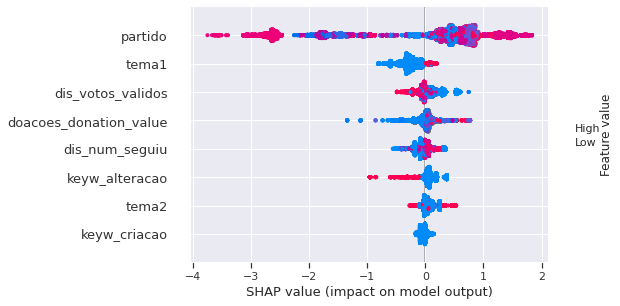

In [70]:
# summary plot (shap values 2-D)
shap.summary_plot(
    shap_values[1],
    X,
    feature_names=features)

## DICE

In [71]:
selected_iter = stats['iter_max_auc']
X = stats[selected_iter]['X_test']
y = stats[selected_iter]['y_test']

classifier

LGBMClassifier(boost_from_average=True, learning_rate=0.05, max_bin=512,
               metric='auc', min_data_in_leaf=5, num_leaves=150,
               objective='binary', random_state=1, verbose=-1)

In [72]:
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

# DiCE imports
import dice_ml
from dice_ml.utils import helpers  # helper functions



In [168]:
dataset = helpers.load_adult_income_dataset()

In [167]:
adult_info = helpers.get_adult_data_info()
adult_info


{'age': 'age',
 'workclass': 'type of industry (Government, Other/Unknown, Private, Self-Employed)',
 'education': 'education level (Assoc, Bachelors, Doctorate, HS-grad, Masters, Prof-school, School, Some-college)',
 'marital_status': 'marital status (Divorced, Married, Separated, Single, Widowed)',
 'occupation': 'occupation (Blue-Collar, Other/Unknown, Professional, Sales, Service, White-Collar)',
 'race': 'white or other race?',
 'gender': 'male or female?',
 'hours_per_week': 'total work hours per week',
 'income': '0 (<=50K) vs 1 (>50K)'}

In [170]:
dataset.occupation

0        White-Collar
1        Professional
2        White-Collar
3             Service
4        White-Collar
             ...     
26043    White-Collar
26044     Blue-Collar
26045    White-Collar
26046    White-Collar
26047    White-Collar
Name: occupation, Length: 26048, dtype: object

In [121]:
selected_iter = stats['iter_max_auc']
X = stats[selected_iter]['X_test']
y = stats[selected_iter]['y_test']

In [143]:
target = stats[selected_iter]['y_test']
x_train = stats[selected_iter]['X_train']
x_test = df[features].sample(10)

In [171]:
x_test

,partido,tema2,tema1,dis_num_seguiu,doacoes_donation_value,keyw_alteracao,dis_votos_validos,keyw_criacao
200959,25.0,0.0,7.0,27.0,123645.570000,1.0,29.0,0.0
200369,11.0,9.0,2.0,0.0,NaN,1.0,0.0,1.0
30236,24.0,0.0,0.0,0.0,247613.904762,0.0,0.0,0.0
193253,23.0,0.0,0.0,0.0,35735.000000,0.0,0.0,0.0
285437,26.0,0.0,24.0,12.0,16695.000000,1.0,12.0,0.0
292802,23.0,0.0,14.0,22.0,202720.800000,1.0,25.0,0.0
73021,30.0,19.0,7.0,0.0,41000.000000,0.0,0.0,0.0
83841,25.0,22.0,24.0,36.0,1000.000000,1.0,47.0,0.0
106532,25.0,0.0,0.0,1.0,2064.000000,0.0,1.0,0.0
199476,25.0,0.0,0.0,24.0,5755.850000,0.0,24.0,0.0


In [199]:
df[features+['voto']].columns

cont_feat = ['dis_num_seguiu', 'doacoes_donation_value', 'dis_votos_validos','keyw_alteracao','keyw_criacao']+['partido','tema2','tema1']
cat_feat = ['partido','tema2','tema1']

df[cat_feat] = df[cat_feat].astype('float')
x_test = df[features].sample(10)

In [200]:
df.partido

224037     9.0
70819     12.0
224614    21.0
156266    21.0
156857    14.0
          ... 
148877     9.0
69095      0.0
248742    24.0
86439     32.0
225597     3.0
Name: partido, Length: 303505, dtype: float64

In [201]:
d = dice_ml.Data(dataframe=df[features+['voto']], continuous_features=cont_feat,categorical_features=None , outcome_name='voto')

In [202]:
clf = classifier
# model = clf.fit(x_train, y_train)

In [203]:
m = dice_ml.Model(model=model, backend="sklearn")
# Using method=random for generating CFs
exp = dice_ml.Dice(d, m, method="random")

In [204]:
x_test[0:1]

,partido,tema2,tema1,dis_num_seguiu,doacoes_donation_value,keyw_alteracao,dis_votos_validos,keyw_criacao
178629,0.0,14.0,1.0,0.0,1000.0,1.0,0.0,1.0


In [206]:
e1 = exp.generate_counterfactuals(x_test[0:1], total_CFs=10, desired_class="opposite")
e1.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:18<00:00, 18.13s/it]

Query instance (original outcome : 1)


,partido,tema2,tema1,dis_num_seguiu,doacoes_donation_value,keyw_alteracao,dis_votos_validos,keyw_criacao,voto
0,0.0,14.0,1.0,0.0,1000.0,1.0,0.0,1.0,1



Diverse Counterfactual set (new outcome: 0.0)


,partido,tema2,tema1,dis_num_seguiu,doacoes_donation_value,keyw_alteracao,dis_votos_validos,keyw_criacao,voto
0,31.0,-,-,16.1,-,-,-,-,0.0
1,28.7,-,-,-,26406.6,-,-,-,0.0
2,27.1,-,-,-,-,-,-,-,0.0
3,26.9,-,-,-,-,-,-,-,0.0
4,27.1,-,-,-,1272854.2,-,-,-,0.0
5,26.9,-,1.0999999999999999,-,-,-,-,-,0.0
6,9.4,-,-,0.9999999999999999,-,-,-,-,0.0
7,31.4,-,-,-,-,-,8.7,-,0.0
8,30.8,-,-,-,-,-,-,0.6,0.0
9,26.2,-,-,-,-,-,-,-,0.0


In [208]:
e1 = exp.generate_counterfactuals(x_test[3:4], total_CFs=10, desired_class="opposite")
e1.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:19<00:00, 19.13s/it]

Query instance (original outcome : 1)


,partido,tema2,tema1,dis_num_seguiu,doacoes_donation_value,keyw_alteracao,dis_votos_validos,keyw_criacao,voto
0,14.0,0.0,0.0,0.0,326100.0,0.0,0.0,0.0,1



Diverse Counterfactual set (new outcome: 0.0)


,partido,tema2,tema1,dis_num_seguiu,doacoes_donation_value,keyw_alteracao,dis_votos_validos,keyw_criacao,voto
0,-,-,0.7,-,-,-,-,-,0.0
1,8.3,-,-,30.4,-,-,-,-,0.0
2,-,-,0.6,-,-,-,-,-,0.0
3,-,-,0.2,-,-,-,-,-,0.0
4,-,18.4,-,-,-,-,44.3,-,0.0
5,-,22.0,-,-,-,-,36.4,-,0.0
6,-,20.5,-,-,-,-,29.9,-,0.0
7,26.1,10.1,-,-,-,-,-,-,0.0
8,-,18.4,-,-,-,-,27.4,-,0.0
9,27.1,4.3,-,-,-,-,-,-,0.0


In [211]:
e1 = exp.generate_counterfactuals(x_test[4:5], total_CFs=10, desired_class="opposite")
e1.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:19<00:00, 19.02s/it]

Query instance (original outcome : 1)


,partido,tema2,tema1,dis_num_seguiu,doacoes_donation_value,keyw_alteracao,dis_votos_validos,keyw_criacao,voto
0,3.0,14.0,11.0,0.0,10513.200195,1.0,0.0,1.0,1



Diverse Counterfactual set (new outcome: 0.0)


,partido,tema2,tema1,dis_num_seguiu,doacoes_donation_value,keyw_alteracao,dis_votos_validos,keyw_criacao,voto
0,8.0,-,-,-,10513.2,0.3,-,-,0.0
1,20.6,17.5,-,-,10513.2,-,-,-,0.0
2,26.8,-,-,-,10513.2,-,-,-,0.0
3,9.2,-,-,-,10513.2,-,-,0.2,0.0
4,-,-,3.1,-,10513.2,-,36.3,-,0.0
5,8.2,-,-,-,10513.2,-,14.0,-,0.0
6,9.0,-,-,-,10513.2,-,-,-,0.0
7,9.5,-,-,-,10513.2,-,-,0.8,0.0
8,25.8,-,-,-,10513.2,-,-,-,0.0
9,26.3,-,-,-,10513.2,0.0,-,-,0.0


In [212]:
e1 = exp.generate_counterfactuals(x_test[5:6], total_CFs=10, desired_class="opposite")
e1.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:18<00:00, 18.59s/it]

Query instance (original outcome : 0)


,partido,tema2,tema1,dis_num_seguiu,doacoes_donation_value,keyw_alteracao,dis_votos_validos,keyw_criacao,voto
0,21.0,18.0,1.0,5.0,2500.0,0.0,5.0,1.0,0



Diverse Counterfactual set (new outcome: 1.0)


,partido,tema2,tema1,dis_num_seguiu,doacoes_donation_value,keyw_alteracao,dis_votos_validos,keyw_criacao,voto
0,13.4,-,-,-,964891.0,-,-,-,1.0
1,-,-,13.2,-,-,-,-,-,1.0
2,14.0,-,3.2,-,-,-,-,-,1.0
3,-,-,-,-,1131855.7,-,-,-,1.0
4,25.5,-,-,-,-,-,-,-,1.0
5,-,13.3,1.9,-,-,-,-,-,1.0
6,-,3.1,-,5.9,-,-,-,-,1.0
7,20.0,-,-,-,-,-,-,-,1.0
8,0.6,-,-,-,-,0.9,-,-,1.0
9,11.6,-,-,-,-,-,22.6,-,1.0


In [213]:
e1 = exp.generate_counterfactuals(x_test[6:7], total_CFs=10, desired_class="opposite")
e1.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:18<00:00, 18.42s/it]

Query instance (original outcome : 1)


,partido,tema2,tema1,dis_num_seguiu,doacoes_donation_value,keyw_alteracao,dis_votos_validos,keyw_criacao,voto
0,3.0,21.0,12.0,30.0,41169.84375,0.0,35.0,1.0,1



Diverse Counterfactual set (new outcome: 0.0)


,partido,tema2,tema1,dis_num_seguiu,doacoes_donation_value,keyw_alteracao,dis_votos_validos,keyw_criacao,voto
0,26.5,-,-,-,41169.84221804512,-,-,0.1,0.0
1,30.6,-,-,-,41169.84221804512,-,-,0.5,0.0
2,-,-,23.4,-,41169.84221804512,-,-,-,0.0
3,26.9,-,-,-,41169.84221804512,-,-,0.5,0.0
4,-,-,22.8,-,41169.84221804512,-,-,-,0.0
5,27.2,-,-,-,41169.84221804512,-,-,-,0.0
6,-,-,25.1,48.2,41169.84221804512,-,-,-,0.0
7,8.9,-,-,-,1214016.9,-,-,-,0.0
8,-,-,24.8,-,2022178.0,-,-,-,0.0
9,-,-,24.3,-,41169.84221804512,-,-,-,0.0


In [214]:
e1 = exp.generate_counterfactuals(x_test[7:8], total_CFs=10, desired_class="opposite")
e1.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:18<00:00, 18.90s/it]

Query instance (original outcome : 1)


,partido,tema2,tema1,dis_num_seguiu,doacoes_donation_value,keyw_alteracao,dis_votos_validos,keyw_criacao,voto
0,28.0,15.0,17.0,14.0,14854.286133,1.0,15.0,0.0,1



Diverse Counterfactual set (new outcome: 0.0)


,partido,tema2,tema1,dis_num_seguiu,doacoes_donation_value,keyw_alteracao,dis_votos_validos,keyw_criacao,voto
0,27.0,-,22.1,-,14854.285714285714,-,-,-,0.0
1,10.8,-,-,-,14854.285714285714,-,43.4,-,0.0
2,12.8,-,-,-,14854.285714285714,0.9,52.6,-,0.0
3,33.7,-,3.4,-,14854.285714285714,-,-,0.6,0.0
4,27.0,20.0,-,-,14854.285714285714,-,-,-,0.0
5,17.4,-,-,-,14854.285714285714,-,50.7,-,0.0
6,8.0,-,8.7,-,14854.285714285714,-,-,-,0.0
7,11.9,-,-,-,976016.0,-,33.1,-,0.0
8,33.7,-,3.4,-,14854.285714285714,-,-,-,0.0
9,7.8,-,-,-,14854.285714285714,0.5,43.6,-,0.0
